# Churn modeling

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [49]:
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn import tree
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, plot_roc_curve
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest

# Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

In [5]:
# Load dataset
telco = pd.read_csv('data/telco.csv', index_col='customerID')
telco.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [6]:
telco.shape

(7043, 20)

**Understanding Customer Churn :**

**What is Customer Churn?**

Customer churn refers to when a customer ends his or her relationship with a business.

**Why do customers churn?**

Even though there are a variety of factors influencing churn, it mostly comes down to one of the following reasons:

- The customer is frustrated with the product experience.
- The cost for the product exceeds the value it provides.
- The product lacks appropriate customer support.
- Attracting the wrong customers.

**Why do we want to predict churn?**

Acquiring new customers can be several times more expensive than selling to existing ones. Understanding what drives churn and why customers are churning is crucial in maintaining high retention rates. Being able to accurately identify those customers at high risk of churning, may help us to create appropriate marketing strategies and retain our customers.

# EDA

## Types

In [36]:
# Types
telco.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [7]:
# TotalCharges must be encoded as numeric
telco['TotalCharges'] = pd.to_numeric(telco['TotalCharges'], errors='coerce')
telco.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

## Missing values and unique values

In [12]:
# Function to check for unique values, Nan and zeros
def missing_values(data):
    df = pd.DataFrame()
    for col in list(data):
        unique_values = data[col].unique()
        try:
            unique_values = np.sort(unique_values)
        except:
            pass
        nans = round(pd.isna(data[col]).sum()/data.shape[0]*100, 1)
        zeros = round((data[col] == 0).sum()/data.shape[0]*100, 1)
        df = df.append(pd.DataFrame([col, len(unique_values), nans,  zeros]).T, ignore_index = True)
    return df.rename(columns = {0: 'variable',
                                1: 'Unique values',
                                2: 'Nan %',
                                3: 'zeros %'})
                                
missing_values(telco)

,variable,Unique values,Nan %,zeros %
0,gender,2,0.0,0.0
1,SeniorCitizen,2,0.0,83.8
2,Partner,2,0.0,0.0
3,Dependents,2,0.0,0.0
4,tenure,73,0.0,0.2
5,PhoneService,2,0.0,0.0
6,MultipleLines,3,0.0,0.0
7,InternetService,3,0.0,0.0
8,OnlineSecurity,3,0.0,0.0
9,OnlineBackup,3,0.0,0.0


**=>** There is only Nans in TotalCharges. All categorical variables have low cardinality.

## Distribution

### Univariate analysis

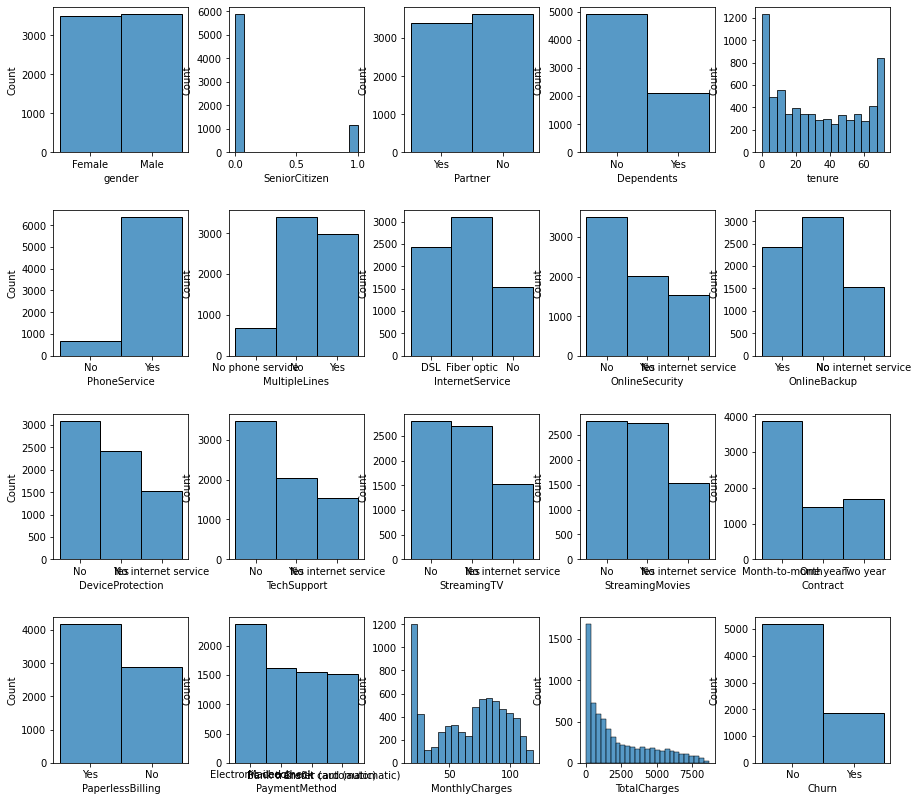

In [15]:
# Univariate analysis
# Let's create histograms for all our variables
fig, ax = plt.subplots(4,5,figsize=(15,12))

plt.subplots_adjust(left=None, bottom=None, right=None, top=1, wspace=0.3, hspace=0.4)

for var, sub in zip(telco.columns, ax.flatten()):
    sns.histplot(telco[var], ax=sub)

### Bivariate analysis with Churn, for numerical variables

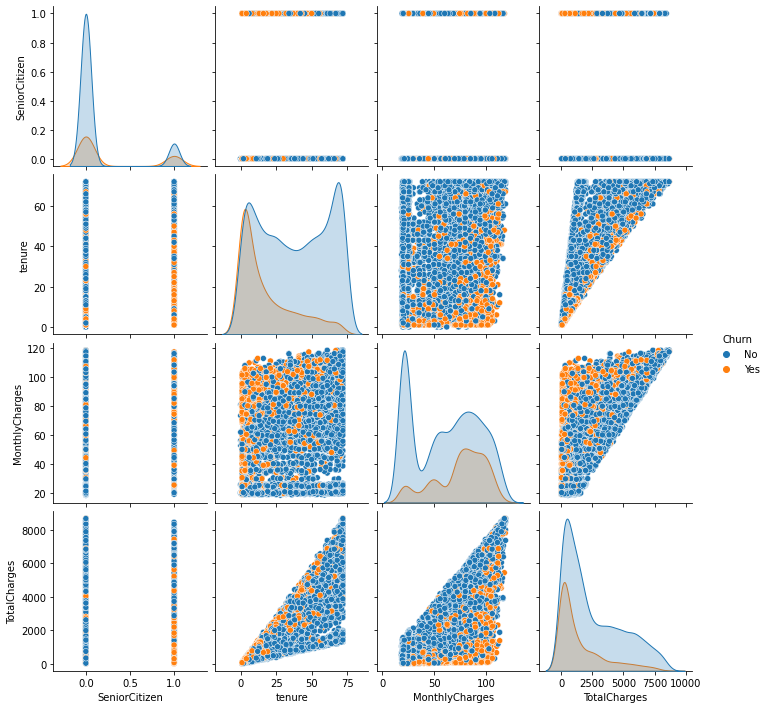

In [17]:
# Bivariate analysis with Churn, for numerical variables
sns.pairplot(data=telco, hue='Churn')
plt.show()

**=>** We can see that churned customers tend to have a lower tenure while at the same time having higher monthly charges.

### Relationship between categorical and numerical variables

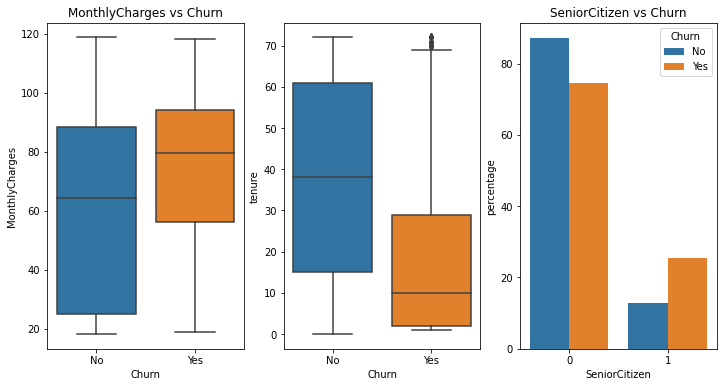

In [22]:
# Relationship between categorical and numerical variables

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,6))

# Are churned customers likely to get charged more ?
plt.subplot(1,3,1)
sns.boxplot(x=telco['Churn'], y=telco['MonthlyCharges'])
plt.title('MonthlyCharges vs Churn')

# When do customers churn ?
plt.subplot(1,3,2)
sns.boxplot(x=telco['Churn'], y=telco['tenure'])

# Are senior citizen more likely to churn ?
plt.subplot(1,3,3)
counts = (telco.groupby(['Churn'])['SeniorCitizen']
          .value_counts(normalize=True)
          .rename('percentage')
          .mul(100)
          .reset_index())
sns.barplot(x='SeniorCitizen', y='percentage', hue='Churn', data=counts).set_title('SeniorCitizen vs Churn');

**=>** We can clearly see from this that monthly charges for churning customers are higher, while tenure is much lower. For senior citizens, there are actually more customers churning than staying with the company. This might be indicative that we’re not focusing on the right customer segment.

### Categorical-categorical relationships

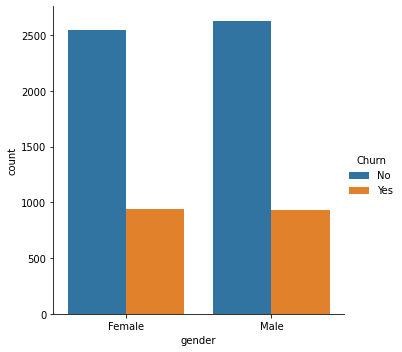

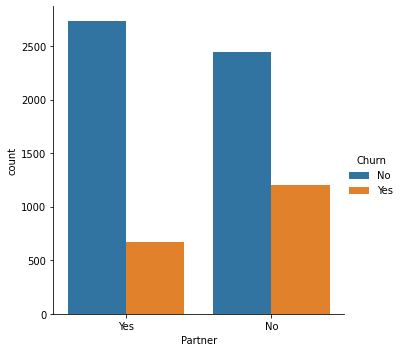

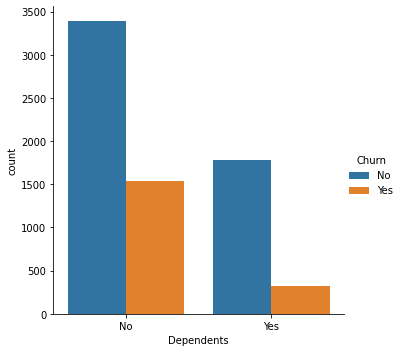

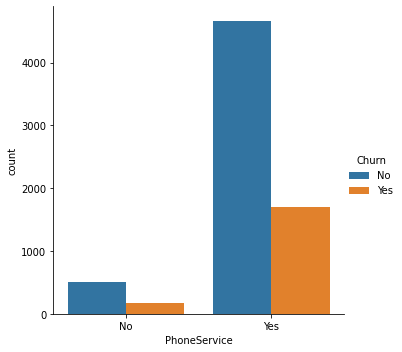

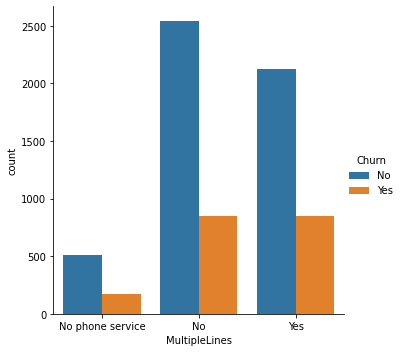

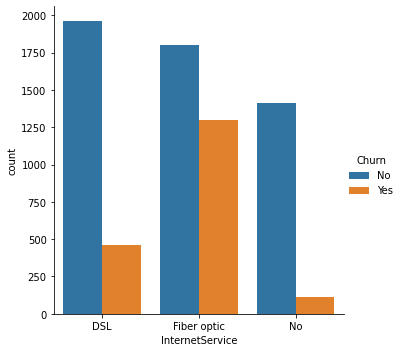

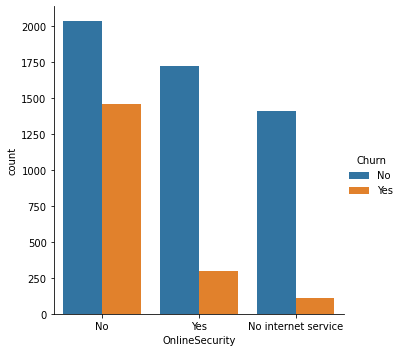

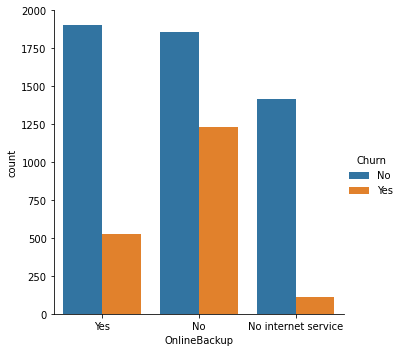

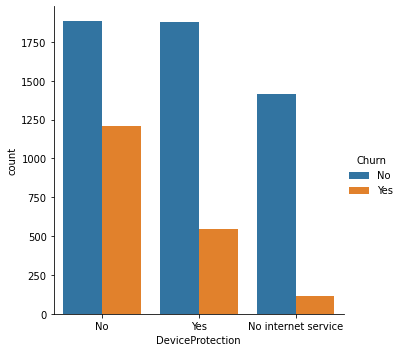

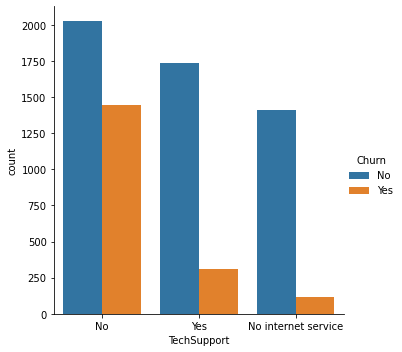

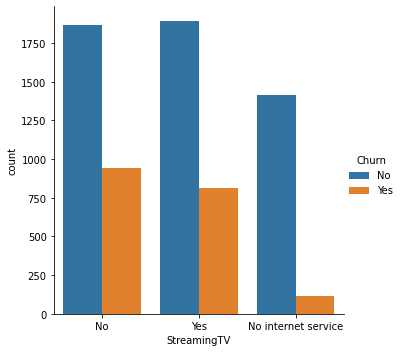

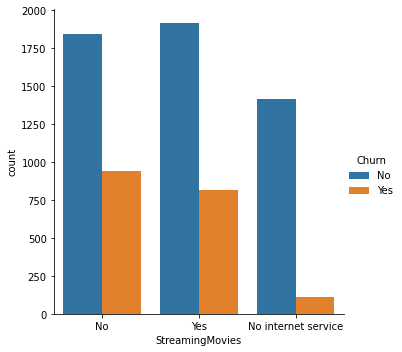

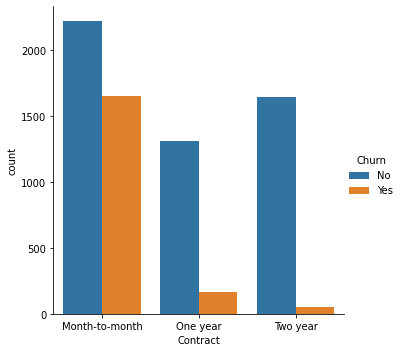

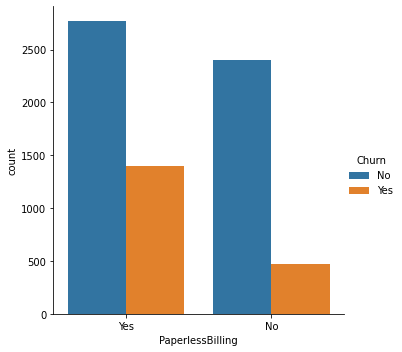

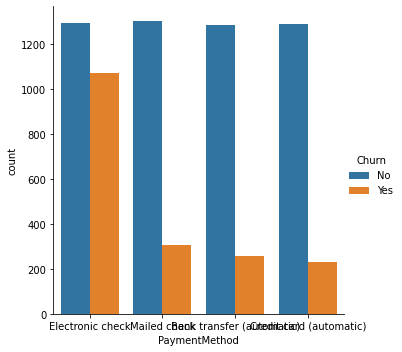

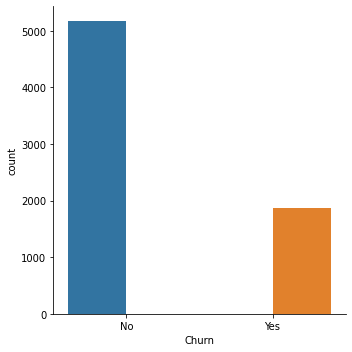

In [24]:
# Catplot for all categorical features vs Churn
for col in telco.select_dtypes(exclude=np.number):
    sns.catplot(x=col, kind='count', hue='Churn', data=telco.select_dtypes(exclude=np.number))

**=>** We can see an important impact for : 
- PaymentMethod : Electronic checMailed
- PaperlessBilling : Yes
- Contract : Month to month
- TechSupport : No
- DeviceProtection : No
- OnlineBackup : No
- Online Security : No
- InternetService : Fiber optic
- Dependents, Partner : No

### Multivariate analysis, heatmap

In [25]:
telco.Churn.unique()

array(['No', 'Yes'], dtype=object)

In [26]:
# To be able to aggregate Churn, we first have to convert it to numeric
telco['Churn'] = telco['Churn'].map({'No':0, 'Yes':1}).astype(int)
telco.Churn.unique()

array([0, 1])

In [28]:
# How does PaymentMethod and Contract type affect churn ?

# Create pivot table
result = pd.pivot_table(data=telco, index='PaymentMethod', columns='Contract', values='Churn')
result

Contract,Month-to-month,One year,Two year
PaymentMethod,,,
Bank transfer (automatic),0.341256,0.097187,0.033688
Credit card (automatic),0.327808,0.103015,0.022375
Electronic check,0.537297,0.184438,0.077381
Mailed check,0.315789,0.068249,0.007853


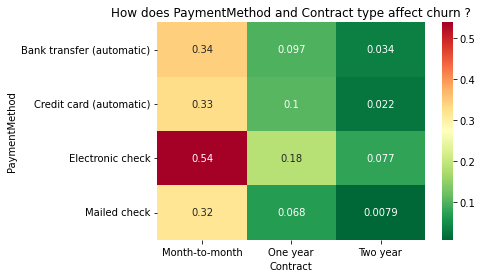

In [31]:
# Let's create a heatmap
sns.heatmap(result, annot=True, cmap='RdYlGn_r')
plt.title('How does PaymentMethod and Contract type affect churn ?')
plt.show()

**=>** We can directly see that customers with a month-to-month contract paying by electronic check are most likely to churn. While those with a two-year contract have a very low probability throughout.

### Conclusions from EDA

Now that we have a better understanding of what’s going on in our data, we can already draw a few conclusions:

- Our target variable is not perfectly balanced. This is important when choosing what algorithm and what evaluation metric we use.
- Most variables in the dataset are categorical. We will need to encode them.
- There are a few NaNs that we need to impute.
- Those paying by electronic check are much more likely to churn.
- It seems that those who have a month-to-month contract are more likely to churn.
- Customers receiving tech support are less likely to churn.
- The ones that contracted Fiber are more likely to churn compared to those with DSL.
- It seems that MonthlyCharges play an important role in whether a customer will stay with the company or not. On the one side, customers that churn, pay on average almost 22% more. While seniors pay as much as 34% more on average - and that's even 37% when they churn.
- SeniorCitizen are also more likely to churn and to stay longer.
- The average tenure is lower for churned customers.

# Preprocessing

In [32]:
missing_values(telco)

,variable,Unique values,Nan %,zeros %
0,gender,2,0.0,0.0
1,SeniorCitizen,2,0.0,83.8
2,Partner,2,0.0,0.0
3,Dependents,2,0.0,0.0
4,tenure,73,0.0,0.2
5,PhoneService,2,0.0,0.0
6,MultipleLines,3,0.0,0.0
7,InternetService,3,0.0,0.0
8,OnlineSecurity,3,0.0,0.0
9,OnlineBackup,3,0.0,0.0


In [50]:
# Train test split
train, test = train_test_split(telco, test_size=0.25)

In [51]:
# Define X & y
X = train.drop(columns='Churn', axis=1)
y = train['Churn']
print(X.shape, y.shape)

(5282, 19) (5282,)


In [52]:
# Select categorical and numercial features
num_feat = X.select_dtypes(include=np.number).columns
cat_feat = X.select_dtypes(exclude=np.number).columns
num_feat

Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')

In [62]:
# Creation of the pipeline
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler(with_mean=False))
])

cat_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder()),
    ('scaler', StandardScaler(with_mean=False))
])

In [63]:
# Preprocessor
preproc = ColumnTransformer([
    ('numerical', num_transformer, num_feat),
    ('categorical', cat_transformer, cat_feat)
], remainder='passthrough')

# Model training

## Finding the best classification model

In [71]:
# Model KNN
pipe = Pipeline(steps=[
        ('preprocesser', preproc),
        ('model classif', KNeighborsClassifier())
])

# Score
score_KNN = cross_val_score(pipe, X, y, cv=5, scoring='roc_auc', verbose=2)
score_KNN.mean()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   0.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.1s finished


0.7782965793391663

In [72]:
# Model SVC
pipe = Pipeline(steps=[
        ('preprocesser', preproc),
        ('model classif', SVC(random_state=123))
])

# Score
score_SVC = cross_val_score(pipe, X, y, cv=5, scoring='roc_auc', verbose=2)
score_SVC.mean()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   0.7s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV] END .................................................... total time=   1.9s
[CV] END .................................................... total time=   0.6s
[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.7s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.5s finished


0.8062452983131763

In [73]:
# Model RandomForest
pipe = Pipeline(steps=[
        ('preprocesser', preproc),
        ('model classif', RandomForestClassifier(random_state=123))
])

# Score
score_Forest = cross_val_score(pipe, X, y, cv=5, scoring='roc_auc', verbose=2)
score_Forest.mean()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   0.4s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] END .................................................... total time=   0.4s
[CV] END .................................................... total time=   0.4s
[CV] END .................................................... total time=   0.4s
[CV] END .................................................... total time=   0.5s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.2s finished


0.8231205741859575

In [74]:
# Model AdaBoost
pipe = Pipeline(steps=[
        ('preprocesser', preproc),
        ('model classif', AdaBoostClassifier(random_state=123))
])

# Score
score_Ada = cross_val_score(pipe, X, y, cv=5, scoring='roc_auc', verbose=2)
score_Ada.mean()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   0.6s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.6s finished


0.847790927593941

In [75]:
# Model GradientBoosting
pipe = Pipeline(steps=[
        ('preprocesser', preproc),
        ('model classif', GradientBoostingClassifier(random_state=123))
])

# Score
score_Grad = cross_val_score(pipe, X, y, cv=5, scoring='roc_auc', verbose=2)
score_Grad.mean()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   0.7s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.6s
[CV] END .................................................... total time=   0.7s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.4s finished


0.8483706226159929

**ROC AUC score :**
Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores.

In [81]:
# Compare scores
classifier_names = [
    'KNeighborsClassifier()',
    'SVC()',
    'RandomForestClassifier()',
    'AdaBoostClassifier()',
    'GradientBoostingClassifier()'
]

classifier_scores = [
    score_KNN.mean(),
    score_SVC.mean(),
    score_Forest.mean(),
    score_Ada.mean(),
    score_Grad.mean()
]

score_df = pd.DataFrame({
    'Classifier' : classifier_names,
    'Cross validated AUC' : classifier_scores
})
score_df.sort_values(by='Cross validated AUC', ascending=False)

,Classifier,Cross validated AUC
4,GradientBoostingClassifier(),0.848371
3,AdaBoostClassifier(),0.847791
2,RandomForestClassifier(),0.823121
1,SVC(),0.806245
0,KNeighborsClassifier(),0.778297


**=>** The Gradient Boosting Classifier has the best score = 0.85

## Fine tune the model

In [83]:
# Final pipeline
# Model GradientBoosting
pipe = Pipeline(steps=[
        ('preprocesser', preproc),
        ('model classif', GradientBoostingClassifier(random_state=123))
])

pipe.get_params()

{'memory': None,
 'steps': [('preprocesser',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('numerical',
                                    Pipeline(steps=[('imputer',
                                                     SimpleImputer(strategy='median')),
                                                    ('scaler',
                                                     StandardScaler(with_mean=False))]),
                                    Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')),
                                   ('categorical',
                                    Pipeline(steps=[('encoder', OneHotEncoder()),
                                                    ('scaler',
                                                     StandardScaler(with_mean=False))]),
                                    Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
          'InternetService', 'OnlineS

In [85]:
# Grid Search
grid = {
    'model classif__max_depth':[1,3,5],
    'model classif__learning_rate':[0.01,0.1,1],
    'model classif__n_estimators':[100,200,300,400]
}

gridsearch = GridSearchCV(estimator=pipe, param_grid=grid, n_jobs=1, scoring='roc_auc', verbose=2)

gridsearch.fit(X,y)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END model classif__learning_rate=0.01, model classif__max_depth=1, model classif__n_estimators=100; total time=   0.3s
[CV] END model classif__learning_rate=0.01, model classif__max_depth=1, model classif__n_estimators=100; total time=   0.3s
[CV] END model classif__learning_rate=0.01, model classif__max_depth=1, model classif__n_estimators=100; total time=   0.3s
[CV] END model classif__learning_rate=0.01, model classif__max_depth=1, model classif__n_estimators=100; total time=   0.3s
[CV] END model classif__learning_rate=0.01, model classif__max_depth=1, model classif__n_estimators=100; total time=   0.3s
[CV] END model classif__learning_rate=0.01, model classif__max_depth=1, model classif__n_estimators=200; total time=   0.5s
[CV] END model classif__learning_rate=0.01, model classif__max_depth=1, model classif__n_estimators=200; total time=   0.6s
[CV] END model classif__learning_rate=0.01, model classif__max_depth=1

[CV] END model classif__learning_rate=0.1, model classif__max_depth=1, model classif__n_estimators=200; total time=   0.5s
[CV] END model classif__learning_rate=0.1, model classif__max_depth=1, model classif__n_estimators=200; total time=   0.6s
[CV] END model classif__learning_rate=0.1, model classif__max_depth=1, model classif__n_estimators=200; total time=   0.5s
[CV] END model classif__learning_rate=0.1, model classif__max_depth=1, model classif__n_estimators=200; total time=   0.5s
[CV] END model classif__learning_rate=0.1, model classif__max_depth=1, model classif__n_estimators=300; total time=   0.8s
[CV] END model classif__learning_rate=0.1, model classif__max_depth=1, model classif__n_estimators=300; total time=   0.8s
[CV] END model classif__learning_rate=0.1, model classif__max_depth=1, model classif__n_estimators=300; total time=   0.8s
[CV] END model classif__learning_rate=0.1, model classif__max_depth=1, model classif__n_estimators=300; total time=   0.8s
[CV] END model c

[CV] END model classif__learning_rate=1, model classif__max_depth=1, model classif__n_estimators=300; total time=   0.8s
[CV] END model classif__learning_rate=1, model classif__max_depth=1, model classif__n_estimators=300; total time=   0.8s
[CV] END model classif__learning_rate=1, model classif__max_depth=1, model classif__n_estimators=400; total time=   1.0s
[CV] END model classif__learning_rate=1, model classif__max_depth=1, model classif__n_estimators=400; total time=   1.0s
[CV] END model classif__learning_rate=1, model classif__max_depth=1, model classif__n_estimators=400; total time=   1.0s
[CV] END model classif__learning_rate=1, model classif__max_depth=1, model classif__n_estimators=400; total time=   1.0s
[CV] END model classif__learning_rate=1, model classif__max_depth=1, model classif__n_estimators=400; total time=   1.0s
[CV] END model classif__learning_rate=1, model classif__max_depth=3, model classif__n_estimators=100; total time=   0.7s
[CV] END model classif__learning

In [89]:
print('best params :', gridsearch.best_params_)
print('best score :', gridsearch.best_score_)

best params : {'model classif__learning_rate': 0.1, 'model classif__max_depth': 1, 'model classif__n_estimators': 300}
best score : 0.8528932574242278


# Prediction on the test set

In [90]:
# Create X test and y test
X_test = test.drop(columns='Churn', axis=1)
y_test = test['Churn']

In [91]:
# Refitting training set with the best params
gridsearch.refit

True

In [92]:
# Create prediction
y_pred = gridsearch.predict(X_test)
y_score = gridsearch.predict_proba(X_test)[:,1]

In [93]:
# Performances
print('AUC_ROC :', roc_auc_score(y_test, y_score))
print('Accuracy :', accuracy_score(y_test, y_pred))

AUC_ROC : 0.8431286380698508
Accuracy : 0.8012492901760363


/home/ameliermd/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


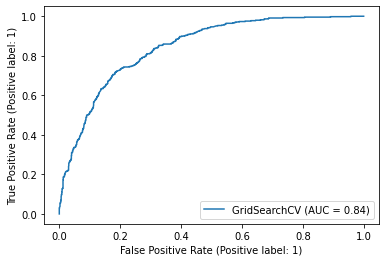

In [96]:
# Plot the ROC curve
plot_roc_curve(gridsearch, X_test, y_test)
plt.show()

**Conclusion :**

We were able to predict churn for new data — in practice this could be for example new customers — with an AUC of 0.84.

An additional step to further improve our model’s performance would be feature engineering — creating new features by combining or transforming existing ones.